### File Explanation

**trainRNN_EncoderModel_learningRate.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', create an "Encoder Network" and train the network with respect to a range of learning rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer dynamic model (function: **dynamicLSTM** using **length** in **trainRNN_network_utils.py**)
<br> 5) Create a single output by using the relevants outputs of encoder models of gene A and gene B
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsEncoderLearningRate_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [5]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [6]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_TT_v3.ipynb"

# Save data into Python file
import pickle
with open('preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [7]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropout = 0.6                                       # dropout percentage

## Training data
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 150
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [18]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for learning_rate in learning_rates:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_A, current_state_A = dynamicLSTM(rSnpRnaA_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastA = last_relevant(hidden_output_A, length(rSnpRnaA_pXNS))

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])

        hidden_output_B, current_state_B = dynamicLSTM(rSnpRnaB_pXNS, 
                                                       n_layer, 
                                                       n_hidden, 
                                                       dropout)
        
        lastB = last_relevant(hidden_output_B, length(rSnpRnaB_pXNS))

    last = tf.math.add(lastA, lastB)

    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')  

    # Dense Layer
    logit = tf.layers.dense(last,
                            units = n_classes, 
                            activation = None,
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(0.3),
                            kernel_initializer = tf.initializers.random_normal() )

    prediction = tf.nn.softmax( logit )
    
    l2 = lambda_l2_reg * sum(
    tf.nn.l2_loss(tf_var)
        for tf_var in tf.trainable_variables()
        if not ("bias" in tf_var.name))

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)) + l2)
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelated_tXC                      
                    })

                tst_loss, tst_acc, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, accuracy, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
    
        trainLosses[learning_rate] = train_losses
        testLosses[learning_rate] = test_losses
        trainAccuracy[learning_rate] = train_accuracies
        F1_scores[learning_rate] = test_f1_score
        print("Optimisation finished!")
        

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


/usr/local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.5674262046813965: Accuracy = 0.30666667222976685
Performance on test set: : Loss = 1.5878206491470337: Accuracy = 0.6276803554552187

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.5511504411697388: Accuracy = 0.3466666638851166
Performance on test set: : Loss = 1.5313490629196167: Accuracy = 0.6916667153773075

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.5026196241378784: Accuracy = 0.3333333432674408
Performance on test set: : Loss = 1.4707340002059937: Accuracy = 0.6826548177092647

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.44831383228302: Accuracy = 0.3733333349227905
Performance on test set: : Loss = 1.5170128345489502: Accuracy = 0.6771784511891111

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.5173627138137817: Accur

Performance on training data: Loss = 1.2903543710708618: Accuracy = 0.3266666531562805
Performance on test set: : Loss = 1.3038197755813599: Accuracy = 0.7224558740439301

Data shuffled. Epoch:  40
Performance on training data: Loss = 1.2987605333328247: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.286792278289795: Accuracy = 0.7216002238685579

Data shuffled. Epoch:  41
Performance on training data: Loss = 1.2685022354125977: Accuracy = 0.35333332419395447
Performance on test set: : Loss = 1.3452801704406738: Accuracy = 0.7228766782450983

Data shuffled. Epoch:  42
Performance on training data: Loss = 1.2508431673049927: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.2861509323120117: Accuracy = 0.7223544823796539

Data shuffled. Epoch:  43
Performance on training data: Loss = 1.2918798923492432: Accuracy = 0.2666666805744171
Performance on test set: : Loss = 1.2775460481643677: Accuracy = 0.7208298275974485

Data shuffled. Epoch:  44
Performanc

Performance on training data: Loss = 1.148650050163269: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.1597999334335327: Accuracy = 0.6910835513847943

Data shuffled. Epoch:  82
Performance on training data: Loss = 1.1487714052200317: Accuracy = 0.31333333253860474
Performance on test set: : Loss = 1.1468297243118286: Accuracy = 0.6913280943248742

Data shuffled. Epoch:  83
Performance on training data: Loss = 1.1513558626174927: Accuracy = 0.2866666615009308
Performance on test set: : Loss = 1.1566219329833984: Accuracy = 0.6892164978258838

Data shuffled. Epoch:  84
Performance on training data: Loss = 1.160097360610962: Accuracy = 0.2666666805744171
Performance on test set: : Loss = 1.1586480140686035: Accuracy = 0.6899658539812425

Data shuffled. Epoch:  85
Performance on training data: Loss = 1.1457737684249878: Accuracy = 0.3266666531562805
Performance on test set: : Loss = 1.1511317491531372: Accuracy = 0.689184666187756

Data shuffled. Epoch:  86
Performance 

Performance on training data: Loss = 1.3762016296386719: Accuracy = 0.2866666615009308
Performance on test set: : Loss = 1.2902246713638306: Accuracy = 0.6928402425976827

Data shuffled. Epoch:  124
Performance on training data: Loss = 1.3292022943496704: Accuracy = 0.31333333253860474
Performance on test set: : Loss = 1.299195408821106: Accuracy = 0.6936545252274672

Data shuffled. Epoch:  125
Performance on training data: Loss = 1.3013771772384644: Accuracy = 0.3266666531562805
Performance on test set: : Loss = 1.2875819206237793: Accuracy = 0.6946562184214634

Data shuffled. Epoch:  126
Performance on training data: Loss = 1.2630665302276611: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.2638494968414307: Accuracy = 0.69563919178569

Data shuffled. Epoch:  127
Performance on training data: Loss = 1.229407548904419: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.2284703254699707: Accuracy = 0.6966039752171299

Data shuffled. Epoch:  128
Performa

Performance on training data: Loss = 1.1496840715408325: Accuracy = 0.36666667461395264
Performance on test set: : Loss = 1.167083740234375: Accuracy = 0.6983555290947796

Data shuffled. Epoch:  166
Performance on training data: Loss = 1.1399492025375366: Accuracy = 0.3733333349227905
Performance on test set: : Loss = 1.151416301727295: Accuracy = 0.6982558961745693

Data shuffled. Epoch:  167
Performance on training data: Loss = 1.125751256942749: Accuracy = 0.3733333349227905
Performance on test set: : Loss = 1.1397485733032227: Accuracy = 0.6983237589510597

Data shuffled. Epoch:  168
Performance on training data: Loss = 1.1400412321090698: Accuracy = 0.3466666638851166
Performance on test set: : Loss = 1.1427183151245117: Accuracy = 0.6982260048976504

Data shuffled. Epoch:  169
Performance on training data: Loss = 1.115075707435608: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.1251498460769653: Accuracy = 0.6982081859671977

Data shuffled. Epoch:  170
Performa

Performance on training data: Loss = 1.0175832509994507: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.2085206508636475: Accuracy = 0.6736709405278689

Data shuffled. Epoch:  8
Performance on training data: Loss = 1.1423916816711426: Accuracy = 0.40666666626930237
Performance on test set: : Loss = 1.1918247938156128: Accuracy = 0.6366863650680354

Data shuffled. Epoch:  9
Performance on training data: Loss = 1.107118844985962: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.2401515245437622: Accuracy = 0.6167336540656286

Data shuffled. Epoch:  10
Performance on training data: Loss = 1.0473263263702393: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 1.2891474962234497: Accuracy = 0.6097438443449347

Data shuffled. Epoch:  11
Performance on training data: Loss = 1.1029404401779175: Accuracy = 0.4466666579246521
Performance on test set: : Loss = 1.1988450288772583: Accuracy = 0.6080417130818236

Data shuffled. Epoch:  12
Performance

Performance on training data: Loss = 1.0077275037765503: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.199175477027893: Accuracy = 0.44098942664000584

Data shuffled. Epoch:  50
Performance on training data: Loss = 0.987799882888794: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.154617428779602: Accuracy = 0.4394822952103323

Data shuffled. Epoch:  51
Performance on training data: Loss = 1.0142741203308105: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.2602413892745972: Accuracy = 0.4385768780468308

Data shuffled. Epoch:  52
Performance on training data: Loss = 0.9860933423042297: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.2333956956863403: Accuracy = 0.43830438325056686

Data shuffled. Epoch:  53
Performance on training data: Loss = 1.005297064781189: Accuracy = 0.5733333230018616
Performance on test set: : Loss = 1.2297871112823486: Accuracy = 0.4377749193117855

Data shuffled. Epoch:  54
Performance on

Performance on training data: Loss = 1.0231717824935913: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.3175934553146362: Accuracy = 0.41586038847030976

Data shuffled. Epoch:  92
Performance on training data: Loss = 1.0049000978469849: Accuracy = 0.54666668176651
Performance on test set: : Loss = 1.2844386100769043: Accuracy = 0.41363702804187297

Data shuffled. Epoch:  93
Performance on training data: Loss = 1.0145726203918457: Accuracy = 0.5266666412353516
Performance on test set: : Loss = 1.3335076570510864: Accuracy = 0.411385404215718

Data shuffled. Epoch:  94
Performance on training data: Loss = 1.0051242113113403: Accuracy = 0.5533333420753479
Performance on test set: : Loss = 1.2935924530029297: Accuracy = 0.40912494296772073

Data shuffled. Epoch:  95
Performance on training data: Loss = 1.045754075050354: Accuracy = 0.5
Performance on test set: : Loss = 1.311372995376587: Accuracy = 0.40697326750154306

Data shuffled. Epoch:  96
Performance on training da

Performance on training data: Loss = 1.1375987529754639: Accuracy = 0.4866666793823242
Performance on test set: : Loss = 1.365782618522644: Accuracy = 0.4051065788213048

Data shuffled. Epoch:  134
Performance on training data: Loss = 1.099153995513916: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.3174968957901: Accuracy = 0.40597977024602716

Data shuffled. Epoch:  135
Performance on training data: Loss = 1.1527881622314453: Accuracy = 0.5
Performance on test set: : Loss = 1.366658091545105: Accuracy = 0.40699488267598605

Data shuffled. Epoch:  136
Performance on training data: Loss = 1.180140733718872: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.3017035722732544: Accuracy = 0.4070817408446874

Data shuffled. Epoch:  137
Performance on training data: Loss = 1.182663083076477: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 1.3097280263900757: Accuracy = 0.4077037574100102

Data shuffled. Epoch:  138
Performance on training 

Performance on training data: Loss = 1.0693168640136719: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.3320300579071045: Accuracy = 0.41947448501988965

Data shuffled. Epoch:  176
Performance on training data: Loss = 1.0783940553665161: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.3409326076507568: Accuracy = 0.4189568854780804

Data shuffled. Epoch:  177
Performance on training data: Loss = 1.0994760990142822: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 1.3307735919952393: Accuracy = 0.4184303406641491

Data shuffled. Epoch:  178
Performance on training data: Loss = 1.1191866397857666: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.3857481479644775: Accuracy = 0.41993770987148005

Data shuffled. Epoch:  179
Performance on training data: Loss = 1.1639703512191772: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.3250727653503418: Accuracy = 0.4211909750781251

Data shuffled. Epoch:  180
P

Performance on training data: Loss = 0.9539470672607422: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1605350971221924: Accuracy = 0.7410596030698912

Data shuffled. Epoch:  18
Performance on training data: Loss = 0.9589182734489441: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.1921520233154297: Accuracy = 0.7434775693902111

Data shuffled. Epoch:  19
Performance on training data: Loss = 0.9473371505737305: Accuracy = 0.5666666626930237
Performance on test set: : Loss = 1.1208088397979736: Accuracy = 0.7453967955021314

Data shuffled. Epoch:  20
Performance on training data: Loss = 0.9238452315330505: Accuracy = 0.6066666841506958
Performance on test set: : Loss = 1.151873230934143: Accuracy = 0.7473853676803854

Data shuffled. Epoch:  21
Performance on training data: Loss = 0.9271204471588135: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.151195764541626: Accuracy = 0.7487638805634

Data shuffled. Epoch:  22
Performance on 

Performance on training data: Loss = 0.9339675903320312: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.132209062576294: Accuracy = 0.7652452036326736

Data shuffled. Epoch:  60
Performance on training data: Loss = 0.8848366141319275: Accuracy = 0.6866666674613953
Performance on test set: : Loss = 1.1882128715515137: Accuracy = 0.7651630700808528

Data shuffled. Epoch:  61
Performance on training data: Loss = 0.8914016485214233: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.1937817335128784: Accuracy = 0.7651732369742661

Data shuffled. Epoch:  62
Performance on training data: Loss = 0.8214865326881409: Accuracy = 0.7599999904632568
Performance on test set: : Loss = 1.2131989002227783: Accuracy = 0.7652390850867883

Data shuffled. Epoch:  63
Performance on training data: Loss = 0.8697366118431091: Accuracy = 0.699999988079071
Performance on test set: : Loss = 1.1982693672180176: Accuracy = 0.7652477065368193

Data shuffled. Epoch:  64
Performance 

Performance on training data: Loss = 0.8946272730827332: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2306220531463623: Accuracy = 0.7558062056048098

Data shuffled. Epoch:  102
Performance on training data: Loss = 0.9154579639434814: Accuracy = 0.6466666460037231
Performance on test set: : Loss = 1.251096487045288: Accuracy = 0.75552108567104

Data shuffled. Epoch:  103
Performance on training data: Loss = 0.8505539298057556: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.2102081775665283: Accuracy = 0.7551786782531059

Data shuffled. Epoch:  104
Performance on training data: Loss = 0.8933931589126587: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2563260793685913: Accuracy = 0.7548908567361121

Data shuffled. Epoch:  105
Performance on training data: Loss = 0.8603098392486572: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.2034356594085693: Accuracy = 0.7546833497792192

Data shuffled. Epoch:  106
Performa

Performance on training data: Loss = 0.8030592799186707: Accuracy = 0.7733333110809326
Performance on test set: : Loss = 1.1810147762298584: Accuracy = 0.7530708109055241

Data shuffled. Epoch:  144
Performance on training data: Loss = 0.7917457818984985: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.1910336017608643: Accuracy = 0.7530120027654257

Data shuffled. Epoch:  145
Performance on training data: Loss = 0.852886974811554: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.165834665298462: Accuracy = 0.7530157023853455

Data shuffled. Epoch:  146
Performance on training data: Loss = 0.8382587432861328: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.1932276487350464: Accuracy = 0.753007138087949

Data shuffled. Epoch:  147
Performance on training data: Loss = 0.836208164691925: Accuracy = 0.7333333492279053
Performance on test set: : Loss = 1.225119709968567: Accuracy = 0.7529864837656709

Data shuffled. Epoch:  148
Performanc

Performance on training data: Loss = 0.8492186069488525: Accuracy = 0.7200000286102295
Performance on test set: : Loss = 1.2478382587432861: Accuracy = 0.7505040160274641

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.8954949975013733: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.1792763471603394: Accuracy = 0.7501909199933289

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.8645768165588379: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.222684621810913: Accuracy = 0.7499271131110871

Data shuffled. Epoch:  188
Performance on training data: Loss = 0.8267877697944641: Accuracy = 0.746666669845581
Performance on test set: : Loss = 1.2048701047897339: Accuracy = 0.7496182629202328

Data shuffled. Epoch:  189
Performance on training data: Loss = 0.8279292583465576: Accuracy = 0.7400000095367432
Performance on test set: : Loss = 1.2673457860946655: Accuracy = 0.7492973264976022

Data shuffled. Epoch:  190
Perform

Performance on training data: Loss = 1.076008915901184: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 1.2310340404510498: Accuracy = 0.5939417108222598

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.0688592195510864: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 1.1412068605422974: Accuracy = 0.592981604510987

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.0751898288726807: Accuracy = 0.4533333480358124
Performance on test set: : Loss = 1.1554710865020752: Accuracy = 0.5908464935296885

Data shuffled. Epoch:  30
Performance on training data: Loss = 1.0729893445968628: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.2004122734069824: Accuracy = 0.5907143592643241

Data shuffled. Epoch:  31
Performance on training data: Loss = 1.0742565393447876: Accuracy = 0.4466666579246521
Performance on test set: : Loss = 1.1487692594528198: Accuracy = 0.5900572505989327

Data shuffled. Epoch:  32
Performance

Performance on training data: Loss = 0.9677146673202515: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1536579132080078: Accuracy = 0.5887548041239108

Data shuffled. Epoch:  70
Performance on training data: Loss = 0.9693324565887451: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.19041109085083: Accuracy = 0.5887975158533084

Data shuffled. Epoch:  71
Performance on training data: Loss = 0.9334300756454468: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.1656780242919922: Accuracy = 0.5890054143381018

Data shuffled. Epoch:  72
Performance on training data: Loss = 0.9532871246337891: Accuracy = 0.6133333444595337
Performance on test set: : Loss = 1.2079087495803833: Accuracy = 0.5891821728470924

Data shuffled. Epoch:  73
Performance on training data: Loss = 0.9792777299880981: Accuracy = 0.5333333611488342
Performance on test set: : Loss = 1.248186707496643: Accuracy = 0.5892774862660008

Data shuffled. Epoch:  74
Performance o

Performance on training data: Loss = 0.9261379837989807: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1817774772644043: Accuracy = 0.5721898980549024

Data shuffled. Epoch:  112
Performance on training data: Loss = 0.9155316352844238: Accuracy = 0.6333333253860474
Performance on test set: : Loss = 1.2344636917114258: Accuracy = 0.5718521236488984

Data shuffled. Epoch:  113
Performance on training data: Loss = 0.875977098941803: Accuracy = 0.7066666483879089
Performance on test set: : Loss = 1.2060984373092651: Accuracy = 0.57107234578188

Data shuffled. Epoch:  114
Performance on training data: Loss = 0.9072170257568359: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.2111297845840454: Accuracy = 0.570590608602864

Data shuffled. Epoch:  115
Performance on training data: Loss = 0.8873504400253296: Accuracy = 0.6666666865348816
Performance on test set: : Loss = 1.206738829612732: Accuracy = 0.5699007756155494

Data shuffled. Epoch:  116
Performanc

Performance on training data: Loss = 0.8474941849708557: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.173318862915039: Accuracy = 0.5450426319869089

Data shuffled. Epoch:  154
Performance on training data: Loss = 0.9023236036300659: Accuracy = 0.6733333468437195
Performance on test set: : Loss = 1.2995843887329102: Accuracy = 0.5443158964618692

Data shuffled. Epoch:  155
Performance on training data: Loss = 0.9487064480781555: Accuracy = 0.6266666650772095
Performance on test set: : Loss = 1.2853443622589111: Accuracy = 0.5436937388335227

Data shuffled. Epoch:  156
Performance on training data: Loss = 0.8807912468910217: Accuracy = 0.6933333277702332
Performance on test set: : Loss = 1.2132536172866821: Accuracy = 0.543087770161993

Data shuffled. Epoch:  157
Performance on training data: Loss = 0.8988685011863708: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1964048147201538: Accuracy = 0.5425645800677434

Data shuffled. Epoch:  158
Perform

Performance on training data: Loss = 0.7786052227020264: Accuracy = 0.8133333325386047
Performance on test set: : Loss = 1.2104878425598145: Accuracy = 0.5261037912857609

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.9025099873542786: Accuracy = 0.6800000071525574
Performance on test set: : Loss = 1.2648754119873047: Accuracy = 0.5255904047566498

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.8525760769844055: Accuracy = 0.7133333086967468
Performance on test set: : Loss = 1.2552392482757568: Accuracy = 0.5251141137156988

Data shuffled. Epoch:  198
Performance on training data: Loss = 0.8491230607032776: Accuracy = 0.7266666889190674
Performance on test set: : Loss = 1.2290178537368774: Accuracy = 0.5245547391607491

Data shuffled. Epoch:  199
Performance on training data: Loss = 0.8265361189842224: Accuracy = 0.7799999713897705
Performance on test set: : Loss = 1.240255355834961: Accuracy = 0.5240560486528599

Optimisation finished!
Data shuff

Performance on training data: Loss = 1.1685482263565063: Accuracy = 0.31333333253860474
Performance on test set: : Loss = 1.1436985731124878: Accuracy = 0.6410833697867784

Data shuffled. Epoch:  38
Performance on training data: Loss = 1.178900122642517: Accuracy = 0.2666666805744171
Performance on test set: : Loss = 1.2005101442337036: Accuracy = 0.6409121304392865

Data shuffled. Epoch:  39
Performance on training data: Loss = 1.1835150718688965: Accuracy = 0.273333340883255
Performance on test set: : Loss = 1.1910386085510254: Accuracy = 0.6411262065471363

Data shuffled. Epoch:  40
Performance on training data: Loss = 1.1756409406661987: Accuracy = 0.3199999928474426
Performance on test set: : Loss = 1.139380693435669: Accuracy = 0.6411357041385889

Data shuffled. Epoch:  41
Performance on training data: Loss = 1.1718480587005615: Accuracy = 0.2933333218097687
Performance on test set: : Loss = 1.206145167350769: Accuracy = 0.6418411801926585

Data shuffled. Epoch:  42
Performance o

Performance on training data: Loss = 1.1558834314346313: Accuracy = 0.3333333432674408
Performance on test set: : Loss = 1.1502138376235962: Accuracy = 0.6520374341816737

Data shuffled. Epoch:  80
Performance on training data: Loss = 1.1621778011322021: Accuracy = 0.30666667222976685
Performance on test set: : Loss = 1.120464563369751: Accuracy = 0.6521720709962785

Data shuffled. Epoch:  81
Performance on training data: Loss = 1.133865475654602: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1832681894302368: Accuracy = 0.6523189441970162

Data shuffled. Epoch:  82
Performance on training data: Loss = 1.135484218597412: Accuracy = 0.35333332419395447
Performance on test set: : Loss = 1.1087276935577393: Accuracy = 0.6522756989218255

Data shuffled. Epoch:  83
Performance on training data: Loss = 1.150012493133545: Accuracy = 0.3466666638851166
Performance on test set: : Loss = 1.1425501108169556: Accuracy = 0.6523136037334256

Data shuffled. Epoch:  84
Performance

Performance on training data: Loss = 1.1196874380111694: Accuracy = 0.3866666555404663
Performance on test set: : Loss = 1.1916375160217285: Accuracy = 0.6486478843210884

Data shuffled. Epoch:  122
Performance on training data: Loss = 1.1386646032333374: Accuracy = 0.3933333456516266
Performance on test set: : Loss = 1.184274435043335: Accuracy = 0.64841962891522

Data shuffled. Epoch:  123
Performance on training data: Loss = 1.0901471376419067: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.1868188381195068: Accuracy = 0.6479581622587108

Data shuffled. Epoch:  124
Performance on training data: Loss = 1.1251484155654907: Accuracy = 0.3866666555404663
Performance on test set: : Loss = 1.173920750617981: Accuracy = 0.6474032964568268

Data shuffled. Epoch:  125
Performance on training data: Loss = 1.1088815927505493: Accuracy = 0.41333332657814026
Performance on test set: : Loss = 1.2194041013717651: Accuracy = 0.6469571921749137

Data shuffled. Epoch:  126
Perform

Performance on training data: Loss = 1.1099025011062622: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.1934117078781128: Accuracy = 0.6301778457531338

Data shuffled. Epoch:  164
Performance on training data: Loss = 1.1166205406188965: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 1.2053637504577637: Accuracy = 0.6297870103704062

Data shuffled. Epoch:  165
Performance on training data: Loss = 1.0936710834503174: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1459699869155884: Accuracy = 0.6294392963603299

Data shuffled. Epoch:  166
Performance on training data: Loss = 1.084770679473877: Accuracy = 0.4533333480358124
Performance on test set: : Loss = 1.2158150672912598: Accuracy = 0.6292183567123877

Data shuffled. Epoch:  167
Performance on training data: Loss = 1.0834133625030518: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.216334581375122: Accuracy = 0.6289331946434241

Data shuffled. Epoch:  168
Perfo

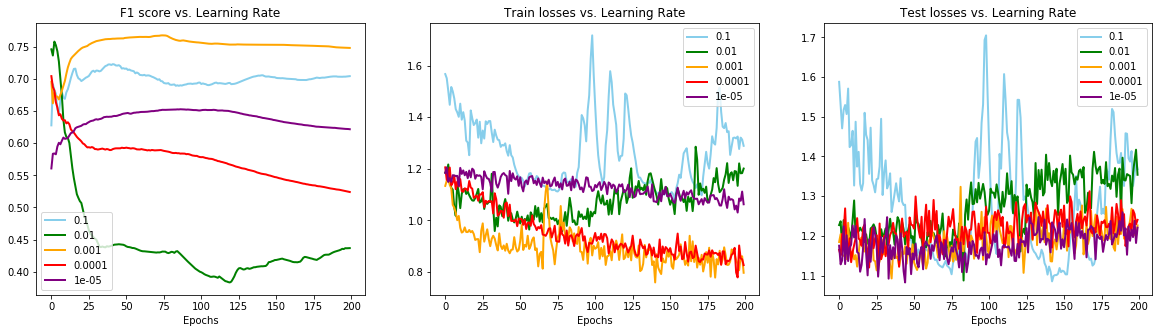

In [19]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, 'Learning Rate')

In [20]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsEncoderLearningRate_ANM.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
